In [1]:
from mystatsfunctions import OLSE,LMoments

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sn

# Ordinary least square estimator (OLSE)
The OLSE module contains two classes for efficiently computing linear regressions via least squares. These are detailed below.

### simple
`OLSE.simple()` computes a simple linear regression using explicit array formulae. This means that is can be broadcasted across arrays for point-by-point regression analysis. This makes it very useful for efficiently testing linear relationships between two (but only two) variables.

### multiple
`OLSE.multiple()` calculates an ordinary least squares estimator for any number of features & targets. It uses the least-squares matrix solution to the linear model; hence cannot be broadcast generally.

# L-moments (LMoments)

## Distributions contained in the LMoments module:

| Distribution |  accessor   | parameters |
| ----------- | ----------- | ----------- |
| Generalised extreme value | `gev`    | `k,X,a` |
| Generalised pareto  | `gpd`   |`k,X,a` |
| Generalised logistic |  `glo`   | `k,X,a` |
| Weibull   | `weib`   | `k,X,a` |
| Gamma    | `gam`  | `a,B` |
| Normal   | `norm`   | `X,a` |

The definitions of these distributions & parameters used in this module are given in:

Hosking, J. R. M. (1990). L-Moments: Analysis and Estimation of Distributions Using Linear Combinations of Order Statistics. Journal of the Royal Statistical Society: Series B (Methodological), 52(1), 105–124. https://doi.org/10.1111/j.2517-6161.1990.tb01775.x

Hosking, J. R. M., & Wallis, J. R. (1997). Regional Frequency Analysis. In Regional Frequency Analysis. Cambridge University Press. https://doi.org/10.1017/cbo9780511529443

Goda, Y., Kudaka, M., & Kawai, H. (2011). Incorporation of Weibull Distribution in L-Moments Method for. Coastal Engineering Proceedings, 1(32), 62. https://doi.org/10.9753/icce.v32.waves.62

#### example usage
Here I demonstrate a "classic" example of one way to use this package - bootstrapping the confidence in a model fit. This demo uses pretty much every method available in the package.

In [2]:
# generate sample data
test_data = sp.stats.genextreme(0.15,35,1.5).rvs(100)

In [3]:
# randomly sample from this test data and reshape
N_boot = 1000
test_boot = test_data[np.random.choice(test_data.size,test_data.size*N_boot)].reshape(test_data.size,N_boot)

In [4]:
# initialise a GEV object
gev_fit = LMoments.gev()

# fit to the data
%time gev_fit.fit(test_boot)

CPU times: user 35.3 ms, sys: 2.46 ms, total: 37.8 ms
Wall time: 37.7 ms


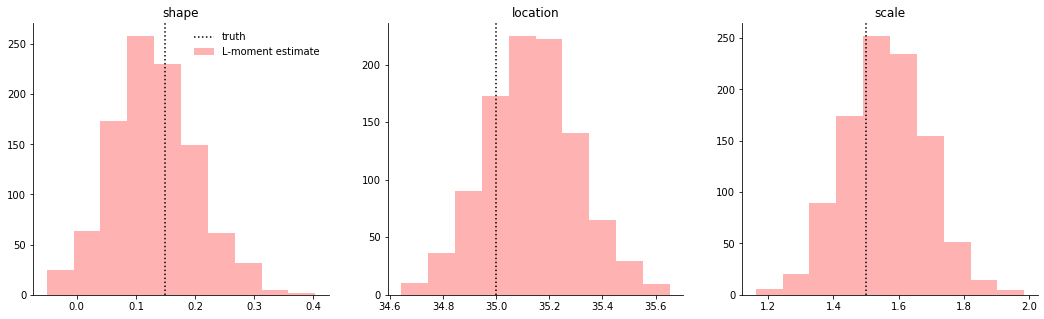

In [5]:
# parameter estimate distributions
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].hist(gev_fit.k,color='r',alpha=0.3,label='L-moment estimate')
ax[1].hist(gev_fit.X,color='r',alpha=0.3)
ax[2].hist(gev_fit.a,color='r',alpha=0.3)

ax[0].axvline(0.15,color='k',ls=':',label='truth')
ax[1].axvline(35,color='k',ls=':')
ax[2].axvline(1.5,color='k',ls=':')

sn.despine()
ax[0].set_title('shape')
ax[1].set_title('location')
ax[2].set_title('scale')
ax[0].legend(frameon=False)

/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:246: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:246: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:233: RuntimeWarning: invalid value encountered in power
  pdf = (1/self.a) * ( 1-self.k*( (x-self.X)/self.a ) )**( (1/self.k)-1 ) * np.exp( -1*(1-self.k*( (x-self.X)/self.a) )**(1/self.k) )
/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:233: RuntimeWarning: invalid value encountered in power
  pdf = (1/self.a) * ( 1-self.k*( (x-self.X)/self.a ) )**( (1/self.k)-1 ) * np.exp( -1*(1-self.k*( (x-self.X)/self.a) )**(1/self.k) )


Text(0.5, 1.0, 'PDF')

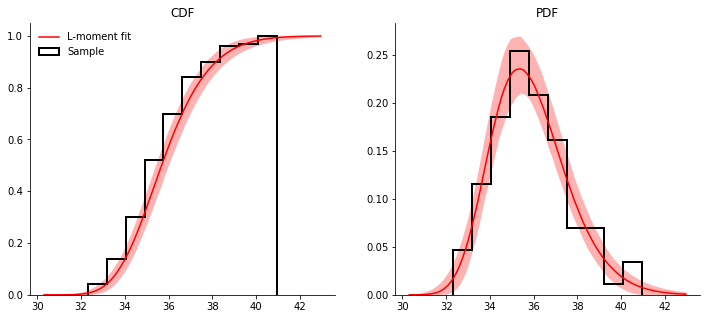

In [6]:
# example useage of cdf and pdf of fit
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(test_data,cumulative=True,histtype='step',color='k',linewidth=2,density=True,label='Sample')
ax[1].hist(test_data,cumulative=False,histtype='step',color='k',linewidth=2,density=True)

xrange = np.linspace(test_data.min()-2,test_data.max()+2,100)

# remember you need to broadcast the input x range appropriately!
ax[0].plot(xrange,np.median(gev_fit.cdf(xrange[:,None]),axis=1),color='r',label='L-moment fit')
ax[0].fill_between(xrange,*np.quantile(gev_fit.cdf(xrange[:,None]),[0.05,0.95],axis=1),color='r',alpha=0.3,lw=0)

ax[1].plot(xrange,np.median(gev_fit.pdf(xrange[:,None]),axis=1),color='r')
ax[1].fill_between(xrange,*np.quantile(gev_fit.pdf(xrange[:,None]),[0.05,0.95],axis=1),color='r',alpha=0.3,lw=0)

sn.despine()
ax[0].legend(frameon=False)
ax[0].set_title('CDF')
ax[1].set_title('PDF')

In [7]:
# example useage of quantile function

## At what value would a 1 % exceedence event occur?
print('1 % event threshold:',np.median(gev_fit.qf(0.99)),np.quantile(gev_fit.qf(0.99),[0.05,0.95]))

1 % event threshold: 40.574986372556 [39.41932872 41.76412243]


In [8]:
# example useage of random sample generation

## generate 100 samples from each(!) bootstrapped fit = 100,000 member sample
gev_fit.rvs(100).shape

(100, 1000)

In [9]:
# there are a number of other methods that give additional information about the fit:
print('Likelihood:',np.median(gev_fit.likelihood()),np.quantile(gev_fit.likelihood(),[0.05,0.95]),'\n')
print('AIC:',np.median(gev_fit.AIC()),np.quantile(gev_fit.AIC(),[0.05,0.95]),'\n')
print('AICc:',np.median(gev_fit.AICc()),np.quantile(gev_fit.AICc(),[0.05,0.95]),'\n')
print('BIC:',np.median(gev_fit.BIC()),np.quantile(gev_fit.BIC(),[0.05,0.95]),'\n')
print('Anderson-Darling statistic:',np.median(gev_fit.ADts()),np.quantile(gev_fit.ADts(),[0.05,0.95]),'\n')
print('Cramer-von Mises statistic:',np.median(gev_fit.CvMts()),np.quantile(gev_fit.CvMts(),[0.05,0.95]),'\n')
print('Kolmogorov-Smirnov statistic:',np.median(gev_fit.KSts()),np.quantile(gev_fit.KSts(),[0.05,0.95]))

Likelihood: 16.7884642043336 [14.88331573 19.23408041] 

AIC: 0.3586160107924634 [0.08663255 0.59951833] 

AICc: 0.6086160107924634 [0.33663255 0.84951833] 

BIC: 294.35861601079245 [294.08663255 294.59951833] 

Anderson-Darling statistic: 0.3700525946208941 [0.20793845 0.76958066] 

Cramer-von Mises statistic: 0.05216783512428347 [0.02680614 0.11609546] 

Kolmogorov-Smirnov statistic: 0.060797823373435866 [0.0428354  0.08767497]


/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:246: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:166: RuntimeWarning: divide by zero encountered in log
  S = np.einsum('i,i'+dimstr[:self.data.ndim-1]+'->'+dimstr[:self.data.ndim-1], (2*np.arange(1,n+1)-1)/n, np.log(F_data)+np.log(1-F_data[::-1]))


#### testing each distribution
Here I test each distribution graphically over a single large sample

In [10]:
def testplot(scipy_distribution,lmom_equivalent):
    sample = scipy_distribution.rvs(10000)
    # presort for ease
    sample = np.sort(sample)
    
    lmom = lmom_equivalent()
    lmom.fit(sample)
    
    fig,ax = plt.subplots(1,2,figsize=(10,3))
    
    ax[0].plot(sample,np.arange(1,sample.size+1)/sample.size,'k',label='ECDF')
    ax[1].hist(sample,density=True,histtype='step',lw=1,color='k',bins=100)
    
    xrange=np.linspace(sample.min()-1,sample.max()+1,100)
    
    ax[0].plot(xrange,lmom.cdf(xrange),'r:',label='L-Moment estimate')
    ax[1].plot(xrange,lmom.pdf(xrange),'r:')
    
    ax[0].set_title('CDF')
    ax[1].set_title('PDF')
    
    ax[0].legend(frameon=False)
    
    if lmom_equivalent==LMoments.norm:
        fig.suptitle('L-Moment estimates: X ='+str(round(lmom.X,3))+
                     ' ; a ='+str(round(lmom.a,3)),y=1.1,fontweight='bold')
        
    elif lmom_equivalent==LMoments.gam:
        print(type(lmom.B))
        fig.suptitle('L-Moment estimates: a ='+str(round(lmom.a,3))+
                     ' ; B ='+str(round(lmom.B,3)),y=1.1,fontweight='bold')
        
    else:
        fig.suptitle('L-Moment estimates: k ='+str(round(lmom.k,3))+
                     ' ; X ='+str(round(lmom.X,3))+
                     ' ; a ='+str(round(lmom.a,3)),y=1.1,fontweight='bold')

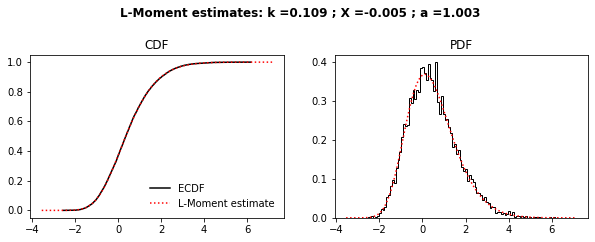

In [11]:
## positive GEV shape
testplot(sp.stats.genextreme(0.1,0,1),LMoments.gev)

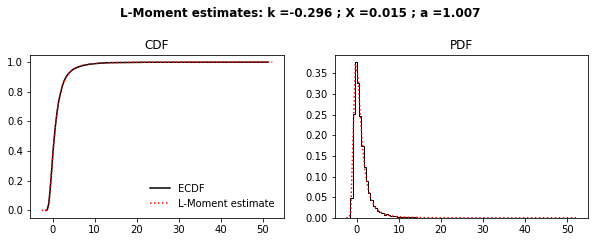

In [12]:
## negative GEV shape
testplot(sp.stats.genextreme(-0.3,0,1),LMoments.gev)

/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:341: RuntimeWarning: invalid value encountered in power
  cdf = 1/( 1 + (1-self.k*(x-self.X)/self.a)**(1/self.k) )
/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:325: RuntimeWarning: invalid value encountered in power
  pdf = (1-self.k*(x-self.X)/self.a)**(1/self.k-1) / ( self.a * ( 1 + (1-self.k*(x-self.X)/self.a)**(1/self.k) )**2 )


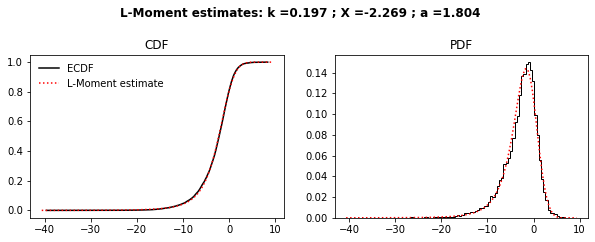

In [13]:
## positive GLo shape (usual caveat that scipy GLo is different...)
testplot(sp.stats.genlogistic(0.3,0,1),LMoments.glo)

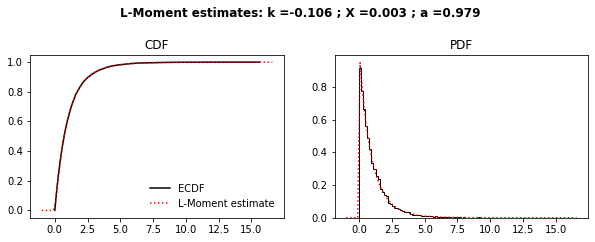

In [14]:
## positive GPD shape (Hosking definition uses negative shape parameter compared to scipy)
testplot(sp.stats.genpareto(0.1,0,1),LMoments.gpd)

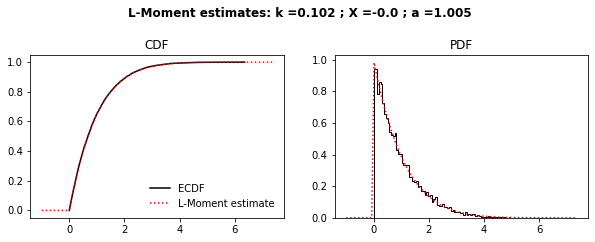

In [15]:
## negative GPD shape (Hosking definition uses negative shape parameter compared to scipy)
testplot(sp.stats.genpareto(-0.1,0,1),LMoments.gpd)

/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:544: RuntimeWarning: invalid value encountered in power
  cdf = 1 - np.exp( -((x-self.X)/self.a)**self.k )
/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:528: RuntimeWarning: invalid value encountered in power
  pdf = self.k/self.a*( (x-self.X)/self.a )**(self.k-1) * np.exp( -((x-self.X)/self.a)**self.k )


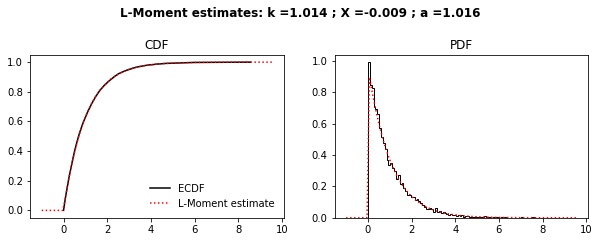

In [16]:
## positive weibull shape (note very low shape parameters highly unstable)
testplot(sp.stats.weibull_min(1,0,1),LMoments.weib)

/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:626: RuntimeWarning: invalid value encountered in power
  pdf = x**(self.a-1) * np.exp(-x/self.B) / (self.B**self.a * sp.special.gamma(self.a))


<class 'numpy.float64'>


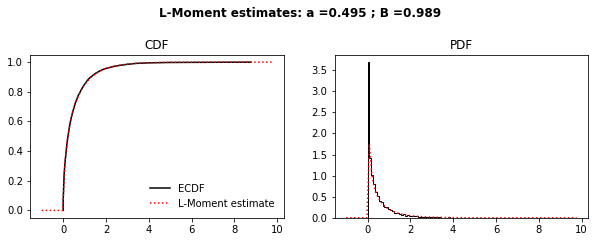

In [17]:
## gamma
testplot(sp.stats.gamma(0.5,0,1),LMoments.gam)

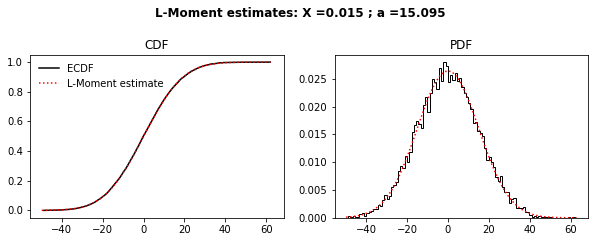

In [18]:
## normal
testplot(sp.stats.norm(0,15),LMoments.norm)

#### comparing L-moments with `scipy.stats.distn.fit`
Here I generate many samples ($1000\times 100$ member samples) drawn from a single underlying distribution, fit these to the specified distributions with L-Moments, `LMoments._distr.fit()` and MLE, `sp.stats.distn.fit()`, and compare the distributions of the parameter estimates.

GEV

In [19]:
## generate multiple samples of the same underlying population:
true_k = -0.1
true_X = 0
true_alph = 1
gev_samples = stats.genextreme(true_k,true_X,true_alph).rvs(100000).reshape(100,1000)

In [20]:
## use LMoments to fit these samples:
lmom = LMoments.gev()
print('L-moments time:')
%time lmom.fit(gev_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.genextreme.fit(x) for x in gev_samples.T])

L-moments time:
CPU times: user 37.7 ms, sys: 365 µs, total: 38 ms
Wall time: 34.8 ms

MLE time
CPU times: user 2min 13s, sys: 367 ms, total: 2min 13s
Wall time: 2min 14s


/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:246: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))


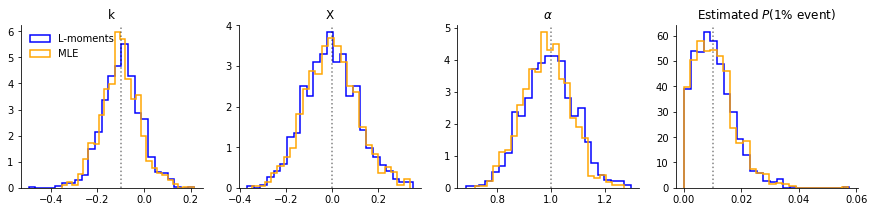

In [21]:
## plot parameter estimates:
fig,ax = plt.subplots(1,4,figsize=(15,3))
param_names = ['k','X',r'$\alpha$']
truth = [true_k,true_X,true_alph]

for i in np.arange(3):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.genextreme(true_k,true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.genextreme(*sp_mle_params.T).cdf(true_1)

ax[3].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[3].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

GLo

Note scipy's generalised logistic distribution is of a different form to the Hosking one used here, hence the model parameter estimates are way off in the LMoments estimates.

In [22]:
## generate multiple samples of the same underlying population:
true_k = 0.1
true_X = 0
true_alph = 1
glo_samples = stats.genlogistic(true_k,true_X,true_alph).rvs(100000).reshape(100,1000)

In [23]:
## use LMoments to fit these samples:
lmom = LMoments.glo()
print('L-moments time:')
%time lmom.fit(glo_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.genlogistic.fit(x) for x in glo_samples.T])

L-moments time:
CPU times: user 30.8 ms, sys: 3.92 ms, total: 34.7 ms
Wall time: 32.8 ms

MLE time
CPU times: user 1min 6s, sys: 596 ms, total: 1min 6s
Wall time: 1min 6s


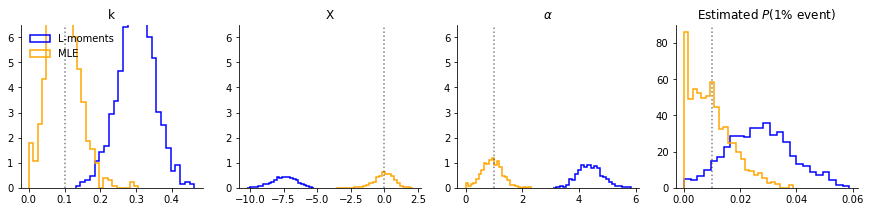

In [24]:
## plot parameter estimates:
fig,ax = plt.subplots(1,4,figsize=(15,3))
param_names = ['k','X',r'$\alpha$']
truth = [true_k,true_X,true_alph]

for i in np.arange(3):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
    ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.genlogistic(true_k,true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.genlogistic(*sp_mle_params.T).cdf(true_1)

ax[3].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[3].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

GPD

Shape parameter defined as the negative of the scipy parameter

In [25]:
## generate multiple samples of the same underlying population:
true_k = -0.1
true_X = 0
true_alph = 1
gpd_samples = stats.genpareto(true_k,true_X,true_alph).rvs(100000).reshape(100,1000)

In [26]:
## use LMoments to fit these samples:
lmom = LMoments.gpd()
print('L-moments time:')
%time lmom.fit(gpd_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.genpareto.fit(x) for x in gpd_samples.T])

L-moments time:
CPU times: user 33.2 ms, sys: 0 ns, total: 33.2 ms
Wall time: 33.3 ms

MLE time
CPU times: user 3min 22s, sys: 405 ms, total: 3min 22s
Wall time: 3min 23s


/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:440: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)


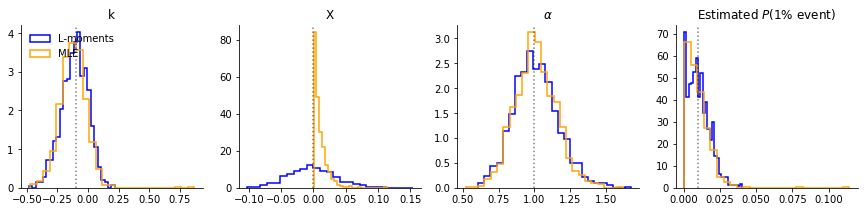

In [27]:
## plot parameter estimates:
fig,ax = plt.subplots(1,4,figsize=(15,3))
param_names = ['k','X',r'$\alpha$']
truth = [true_k,true_X,true_alph]

for i in np.arange(3):
    ax[i].hist(list(lmom.__dict__.values())[i]*[-1,1,1][i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.genpareto(true_k,true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.genpareto(*sp_mle_params.T).cdf(true_1)

ax[3].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[3].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

Weibull

In [28]:
## generate multiple samples of the same underlying population:
true_k = 1
true_X = 0
true_alph = 1
weib_samples = stats.weibull_min(true_k,true_X,true_alph).rvs(100000).reshape(100,1000)

In [29]:
## use LMoments to fit these samples:
lmom = LMoments.weib()
print('L-moments time:')
%time lmom.fit(weib_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.weibull_min.fit(x) for x in weib_samples.T])

L-moments time:
CPU times: user 33 ms, sys: 10 µs, total: 33 ms
Wall time: 33.1 ms

MLE time
CPU times: user 2min 50s, sys: 348 ms, total: 2min 50s
Wall time: 2min 51s


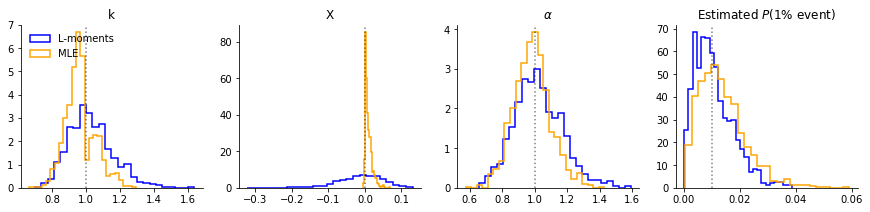

In [30]:
## plot parameter estimates:
fig,ax = plt.subplots(1,4,figsize=(15,3))
param_names = ['k','X',r'$\alpha$']
truth = [true_k,true_X,true_alph]

for i in np.arange(3):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.weibull_min(true_k,true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.weibull_min(*sp_mle_params.T).cdf(true_1)

ax[3].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[3].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

Gamma

In [31]:
## generate multiple samples of the same underlying population:
true_a = 0.5
true_X = 0
true_B = 1
gam_samples = stats.gamma(true_a,true_X,true_B).rvs(100000).reshape(100,1000)

In [32]:
## use LMoments to fit these samples:
lmom = LMoments.gam()
print('L-moments time:')
%time lmom.fit(gam_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.gamma.fit(x,floc=0) for x in gam_samples.T])

L-moments time:
CPU times: user 21.6 ms, sys: 7.95 ms, total: 29.6 ms
Wall time: 26.5 ms

MLE time
CPU times: user 301 ms, sys: 0 ns, total: 301 ms
Wall time: 301 ms


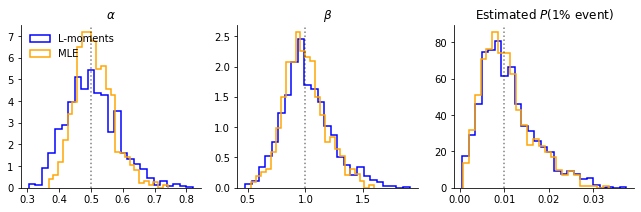

In [33]:
## plot parameter estimates:
fig,ax = plt.subplots(1,3,figsize=(11,3))
param_names = [r'$\alpha$',r'$\beta$']
truth = [true_a,true_B]

for i in np.arange(2):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,[0,2][i]],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.gamma(true_a,true_X,true_B).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.gamma(*sp_mle_params.T).cdf(true_1)

ax[2].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[2].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[2].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[2].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

norm

In [34]:
## generate multiple samples of the same underlying population:
true_X = 0
true_alph = 1
norm_samples = stats.norm(true_X,true_alph).rvs(100000).reshape(100,1000)

In [35]:
## use LMoments to fit these samples:
lmom = LMoments.norm()
print('L-moments time:')
%time lmom.fit(norm_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.norm.fit(x) for x in norm_samples.T])

L-moments time:
CPU times: user 26.3 ms, sys: 22 µs, total: 26.4 ms
Wall time: 24 ms

MLE time
CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 119 ms


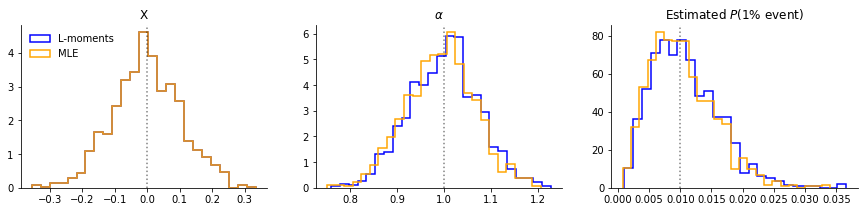

In [36]:
## plot parameter estimates:
fig,ax = plt.subplots(1,3,figsize=(15,3))
param_names = ['X',r'$\alpha$']
truth = [true_X,true_alph]

for i in np.arange(2):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)
    
## and plot the 1 % event estimates:
true_1 = stats.norm(true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.norm(*sp_mle_params.T).cdf(true_1)

ax[-1].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[-1].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[-1].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[-1].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

## Sandbox

In [37]:
import importlib
importlib.reload(LMoments)

<module 'mystatsfunctions.LMoments' from '/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py'>